Windowed Prior

In [8]:
# Dependancies
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tinygp
from tinygp import GaussianProcess, kernels
from stingray import Lightcurve
jax.config.update("jax_enable_x64", True)

import functools

In [2]:
# Mean Model
def gaussian(t, mean_params):
    return mean_params["A"] * jnp.exp(-((t - mean_params["t0"])**2)/(2*(mean_params["sig"]**2)))

# Build Gp
def build_gp(kernel_params, mean_params, t, kernel_type, mean_type = "gaussian", diag = 0.0):
    if kernel_type == "QPO_plus_RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5) + kernels.quasisep.Celerite(
                a = kernel_params["aqpo"], b = 0.0, c = kernel_params["cqpo"], d = 2*jnp.pi*kernel_params["freq"])
    elif kernel_type == "RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5)
    
    # Using partial to make the mean so that it only takes the time value
    if mean_type == "gaussian":
        mean = functools.partial(gaussian, mean_params = mean_params)
        return tinygp.GaussianProcess( kernel, t, mean=mean, diag = diag)
    elif mean_type == "constant":
        mean = mean_params
        return tinygp.GaussianProcess( kernel, t, diag = diag)

In [4]:
# Parameters, kernels for RN, lqpo_rn, hqpo_rn

rnparams = {
    "arn": jnp.exp(1.0),    "crn": jnp.exp(1.0),
    "aqpo": 0.0,    "cqpo": 0.0,    "freq": 0.0
}

rnkernel = kernels.quasisep.Exp(
                scale = 1/rnparams["crn"], sigma = (rnparams["arn"])**0.5)

lqpoparams = {
    "arn" : jnp.exp(1.0),   "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-2),   "cqpo": jnp.exp(1),    "freq": 20
}

lqpokernel = kernels.quasisep.Exp(
    scale = 1/lqpoparams["crn"], sigma = (lqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = lqpoparams["aqpo"], b = 0.0, c = lqpoparams["cqpo"], d = 2*jnp.pi*lqpoparams["freq"])

hqpoparams = {
    "arn" : jnp.exp(1.0),    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 20,
}

hqpokernel = kernels.quasisep.Exp(
    scale = 1/hqpoparams["crn"], sigma = (hqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = hqpoparams["aqpo"], b = 0.0, c = hqpoparams["cqpo"], d = 2*jnp.pi*hqpoparams["freq"])


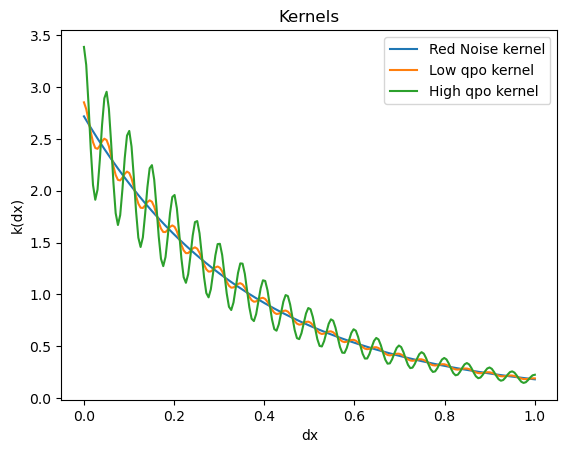

In [5]:
def plot_kernel(kernel, **kwargs):
    """ A function to plot the kernel"""
    dx = np.linspace(0, 1, 200)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    # print(kernel(dx, dx[:1]))
    plt.xlabel("dx")
    plt.legend()
    plt.title("Kernels")
    plt.ylabel("k(dx)")

plot_kernel(rnkernel, label="Red Noise kernel")
plot_kernel(lqpokernel, label="Low qpo kernel")
plot_kernel(hqpokernel, label="High qpo kernel")

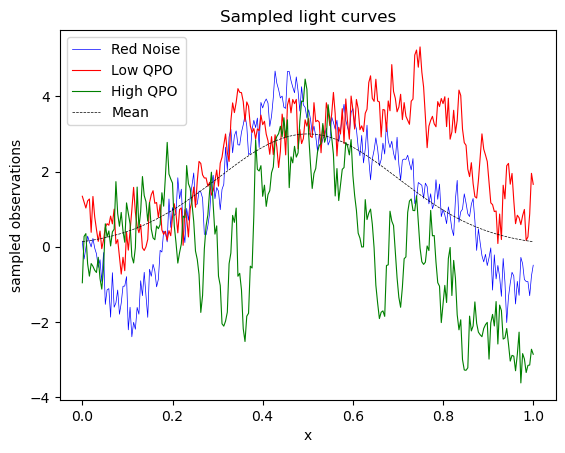

In [6]:
Times = np.linspace(0,1,256)  # 1 secound lightcurve with 256 points

mean_params = {
    "A" : 3,    "t0" : 0.5,    "sig" : 0.2,
}
# stkernel = kernels.Stationary(scale = 0.1)
# wngp = GaussianProcess(kernel = stkernel, X = Times, diag = 0.1)
rngp = build_gp(rnparams, mean_params, Times, kernel_type = "RN", diag = 0.1)
lqpogp = build_gp(lqpoparams, mean_params, Times, kernel_type = "QPO_plus_RN", diag = 0.1)
hqpogp = build_gp(hqpoparams, mean_params, Times, kernel_type = "QPO_plus_RN", diag = 0.1)

rngp_sample   =  rngp.sample( jax.random.PRNGKey(11), shape=(1,))
lqpogp_sample = lqpogp.sample(jax.random.PRNGKey(12), shape=(1,))
hqpogp_sample = hqpogp.sample(jax.random.PRNGKey(13), shape=(1,))

plt.plot(Times, rngp_sample.T, lw=0.5,color = "b" ,label = "Red Noise")
plt.plot(Times, lqpogp_sample.T, lw=0.8, color = "r", label = "Low QPO")
plt.plot(Times, hqpogp_sample.T, lw=0.8, color = "g", label = "High QPO")
plt.plot(Times, rngp.mean_function(Times), color = "k", lw=0.5, ls = "--", label = "Mean")
plt.xlabel("x")
plt.ylabel("sampled observations")
plt.legend()
_ = plt.title("Sampled light curves")

In [7]:
# Calculating evidences using jaxns
# Loading dependencies

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
from jaxns import analytic_log_evidence
from jaxns import Prior, Model

tfpd = tfp.distributions

In [9]:
from tqdm import tqdm
from jax import jit

from jaxns.special_priors import ForcedIdentifiability
Times = jnp.linspace(0,1,256)

def get_evidences(Times, lightcurve):
    results = {}
    def RNprior_model():
        T = Times[-1] - Times[0]    # Total time
        f = 1/(Times[1] - Times[0]) # Sampling frequency
        min = jnp.min(lightcurve)
        max = jnp.max(lightcurve)
        span = max - min

        arn = yield Prior(tfpd.Uniform(0.1*span, 2*span), name='arn') 
        crn = yield Prior(tfpd.Uniform(jnp.log(1/T), jnp.log(f)), name='crn')

        A = yield Prior(tfpd.Uniform(0.1*span, 2*span), name='A') 
        t0 = yield Prior(tfpd.Uniform(Times[0]-0.1*T, Times[-1]+0.1*T), name='t0')
        # t0 = yield ForcedIdentifiability(n = 1, low = Times[0]-0.1*T, high = Times[-1]+0.1*T, name='t0')
        sig = yield Prior(tfpd.Uniform(0.5*1/f, 2*T), name='sig')
        t_window = yield ForcedIdentifiability(n = 2, low = Times[0], high = Times[-1], name='t_window')
        return arn, crn, A, t0, sig , t_window

    def QPOprior_model():
        T = Times[-1] - Times[0]    # Total time
        f = 1/(Times[1] - Times[0]) # Sampling frequency
        min = jnp.min(lightcurve)
        max = jnp.max(lightcurve)
        span = max - min
        
        arn = yield Prior(tfpd.Uniform(0.1*span, 2*span), name='arn')
        crn = yield Prior(tfpd.Uniform(jnp.log(1/T), jnp.log(f)), name='crn')
        aqpo = yield Prior(tfpd.Uniform(0.1*span, 2*span), name='aqpo')
        cqpo = yield Prior(tfpd.Uniform(1/10/T, jnp.log(f)), name='cqpo')
        freq = yield Prior(tfpd.Uniform(2/T, f/2 ), name='freq')

        A = yield Prior(tfpd.Uniform(0.1*span, 2*span), name='A')
        t0 = yield Prior(tfpd.Uniform(Times[0]-0.1*T, Times[-1]+0.1*T), name='t0')
        sig = yield Prior(tfpd.Uniform(0.5*1/f, 2*T), name='sig')
        # t_window = yield ForcedIdentifiability(n = 2, low = Times[0], high = Times[-1], name='t_window')
        return arn, crn, aqpo, cqpo, freq, A, t0, sig #, t_window

    # @jit
    """ 
    -----------------------------------------------------------------------------------------
    """
    # def RNlog_likelihood2(arn, crn, A, t0, sig, t_window):
    #     rnlikelihood_params = {"arn": arn, "crn": crn,
    #                         "aqpo": 0.0, "cqpo": 0.0, "freq": 0.0, }
                
    #     mean_params = { "A": A, "t0": t0, "sig": sig, }
    #     window_minimum = t_window[0]
    #     window_maximum = t_window[1]
    #     # print(f"window_minimum = {window_minimum}")
    #     # print(f"window_maximum = {window_maximum}")
    #     # print(f"Times = {Times}")
    #     # a = jnp.arange(100)
    #     mask = jnp.logical_and(Times > window_minimum, Times < window_maximum)
    #     a = jnp.searchsorted(Times, window_minimum)
    #     b = jnp.searchsorted(Times, window_maximum)
    #     # a = lax.
    #     # windowed_indices = jnp.where(jnp.logical_and(window_minimum < Times, Times < window_maximum))[0]

    #     # gp = build_gp(rnlikelihood_params, mean_params, Times[windowed_indices], kernel_type = "RN")
    #     # return gp.log_probability(lightcurve[windowed_indices])
    #     gp = build_gp(rnlikelihood_params, mean_params, Times[a:b], kernel_type = "RN")
    #     return gp.log_probability(lightcurve[a:b])

    def RNlog_likelihood2(arn, crn, A, t0, sig):
        rnlikelihood_params = {"arn": arn, "crn": crn,
                            "aqpo": 0.0, "cqpo": 0.0, "freq": 0.0, }
                
        mean_params = { "A": A, "t0": t0, "sig": sig, }

        gp = build_gp(rnlikelihood_params, mean_params, Times, kernel_type = "RN")
        return gp.log_probability(lightcurve)

    # @jit
    def QPOlog_likelihood2(arn, crn, aqpo, cqpo, freq,  A, t0, sig):
        qpolikelihood_params = {"arn": arn, "crn": crn,
                                "aqpo": aqpo, "cqpo": cqpo, "freq": freq, }
                
        mean_params = {"A": A, "t0": t0, "sig": sig,}
                
        gp = build_gp(qpolikelihood_params, mean_params, Times, kernel_type = "QPO_plus_RN")
        return gp.log_probability(lightcurve)
            
    RNmodel = Model(prior_model= RNprior_model, log_likelihood=RNlog_likelihood2)
    RNmodel.sanity_check(random.PRNGKey(10), S = 100)
    RNexact_ns = ExactNestedSampler(RNmodel, num_live_points= 500, max_samples= 1e4)
    RNtermination_reason, RNstate = RNexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
    RNresults = RNexact_ns.to_results(RNstate, RNtermination_reason)
    results["RNexact_ns"] = RNexact_ns
    results["RNresults"] = RNresults
    # print(RNresults.log_Z_mean)

    QPOmodel = Model(prior_model= QPOprior_model, log_likelihood=QPOlog_likelihood2)
    QPOexact_ns = ExactNestedSampler(QPOmodel, num_live_points= 500, max_samples= 1e4)
    QPOtermination_reason, QPOstate = QPOexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
    QPOresults = QPOexact_ns.to_results(QPOstate, QPOtermination_reason)
    results["QPOexact_ns"] = QPOexact_ns
    results["QPOresults"] = QPOresults
    # print(QPOresults.log_Z_mean)

    return results

def make_evidence_histogram(n = 1, start = 0):
    BFrn = np.zeros(n)
    BFlqpo = np.zeros(n)
    BFhqpo = np.zeros(n)

    # for i in tqdm(range(n)):
    for i in range(n):
        print(i)
        rngp_sample   = rngp.sample(jax.random.PRNGKey((i+start)**2))
        lqpogp_sample = lqpogp.sample(jax.random.PRNGKey((i+start)**2))
        hqpogp_sample = hqpogp.sample(jax.random.PRNGKey((i+start)**2))
        rn_result = get_evidences(Times, rngp_sample)
        BFrn[i] = rn_result["QPOresults"].log_Z_mean - rn_result["RNresults"].log_Z_mean
        print("BF RN lightcurve ", BFrn[i])
        lqpo_result = get_evidences(Times, lqpogp_sample)
        BFlqpo[i] = lqpo_result["QPOresults"].log_Z_mean - lqpo_result["RNresults"].log_Z_mean
        print("BF LQPO lightcurve ", BFlqpo[i])
        hqpo_result = get_evidences(Times, hqpogp_sample)
        BFhqpo[i] = hqpo_result["QPOresults"].log_Z_mean - hqpo_result["RNresults"].log_Z_mean
        print("BF HQPO lightcurve ", BFhqpo[i] )

    return BFrn, BFlqpo, BFhqpo

In [10]:
lightcurve = hqpogp.sample(jax.random.PRNGKey(4))
print(hqpogp.log_probability(lightcurve))
Results = get_evidences(Times, lightcurve)

-188.19115621086831


ValueError: Invalid mean shape: expected ndim = 1, got ndim=2

In [13]:
window_min = 0.2 ; window_max = 0.4
print(np.searchsorted(Times, window_min))
print(np.searchsorted(Times, window_max))
a = jnp.arange(100)
mask = jnp.logical_and(a > 10, a < 50)
windowed_indices = np.where(np.logical_and(window_min < Times, Times < window_max))[0]
print(windowed_indices)

51
102
[ 52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101]


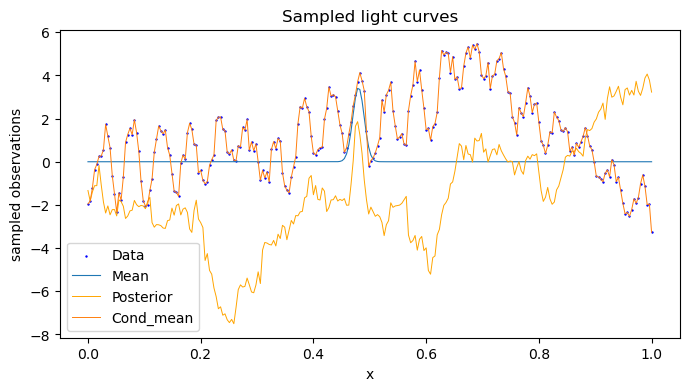

In [41]:
# Plot the lightcurve and the expected model conditioned on the data
# Problem, getting the mean or the max prior value after sampling

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(Times, lightcurve.T, lw=0.7, color = "b", label = "Data", s = 1)

post_rnparams = {
    "arn": 6.05,    "crn": 5.27,
    "aqpo": 0.0,    "cqpo": 0.0,    "freq": 0.0
}
post_rnmeanparams = {
    "A": 3.44,    "t0": 0.48,    "sig": 0.01
}

gp = build_gp(post_rnparams, post_rnmeanparams, Times, kernel_type = "RN")
_ , cond_gp = gp.condition(lightcurve)
ax.plot(Times, gp.mean, lw=0.8, label = "Mean") 
ax.plot(Times, gp.sample(jax.random.PRNGKey(10), shape=(1,)).T, lw=0.7, c = "orange", label = "Posterior")
ax.plot(Times, cond_gp.mean, lw = 0.7, label = "Cond_mean")
ax.set_xlabel("x")
ax.set_ylabel("sampled observations")
ax.legend()
_ = plt.title("Sampled light curves")

In [42]:
Results["RNexact_ns"].summary(Results["RNresults"])

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 419666
# samples: 6652
# slices: 155000.0
# slices / acceptance: 31.0
# likelihood evals / sample: 63.1
# likelihood evals / slice: 2.7
--------
logZ=-262.908 +- 0.086
H=260.0
ESS=1167
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 3.1 +- 2.2 | 1.1 / 2.5 / 5.8 | 3.7 | 3.7
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 13.2 +- 2.1 | 10.6 / 12.9 / 16.5 | 10.9 | 10.9
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 4.41 +- 0.65 | 3.49 / 4.43 / 5.29 | 5.3 | 5.3
--------
sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sig: 0.82 +- 0.6 | 0.12 / 0.69 / 1.75 | 0.01 | 0.01
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.52 +- 0.32 | 0.06 / 0.53 / 0.97 | 0.48 | 0.48
--------


WARNING[2023-06-14 14:16:13,232]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


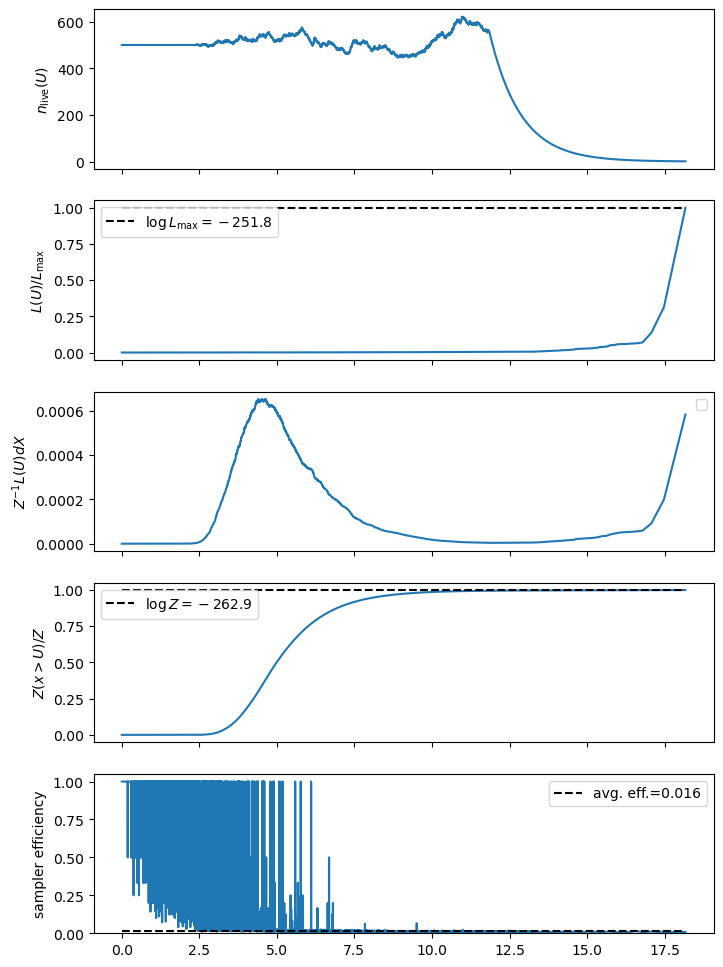

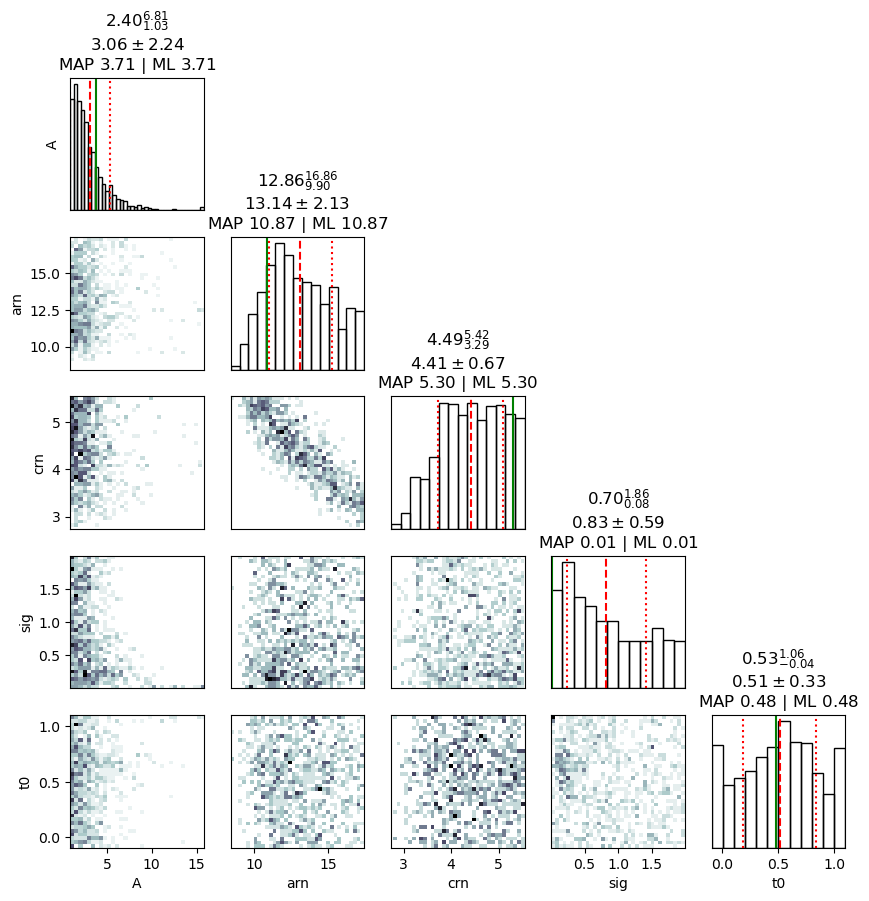

In [43]:
Results["RNexact_ns"].plot_diagnostics(Results["RNresults"])
Results["RNexact_ns"].plot_cornerplot(Results["RNresults"])

In [44]:
Results["QPOexact_ns"].summary(Results["QPOresults"])

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1601321
# samples: 10000
# slices: 409052.0
# slices / acceptance: 49.0
# likelihood evals / sample: 160.1
# likelihood evals / slice: 3.9
--------
logZ=-212.58 +- 0.15
H=210.0
ESS=1820
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 2.5 +- 1.2 | 1.1 / 2.4 / 4.2 | 2.9 | 2.9
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 3.3 +- 1.6 | 1.3 / 3.0 / 5.3 | 1.1 | 1.1
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 8.2 +- 2.9 | 5.8 / 7.3 / 13.7 | 7.1 | 7.1
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 0.25 +- 0.23 | 0.11 / 0.17 / 0.46 | 0.17 | 0.17
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 4.25 +- 0.91 | 2.51 / 4.42 / 5.3 | 4.51 | 4.51
--------
freq: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est

WARNING[2023-06-14 14:16:27,841]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


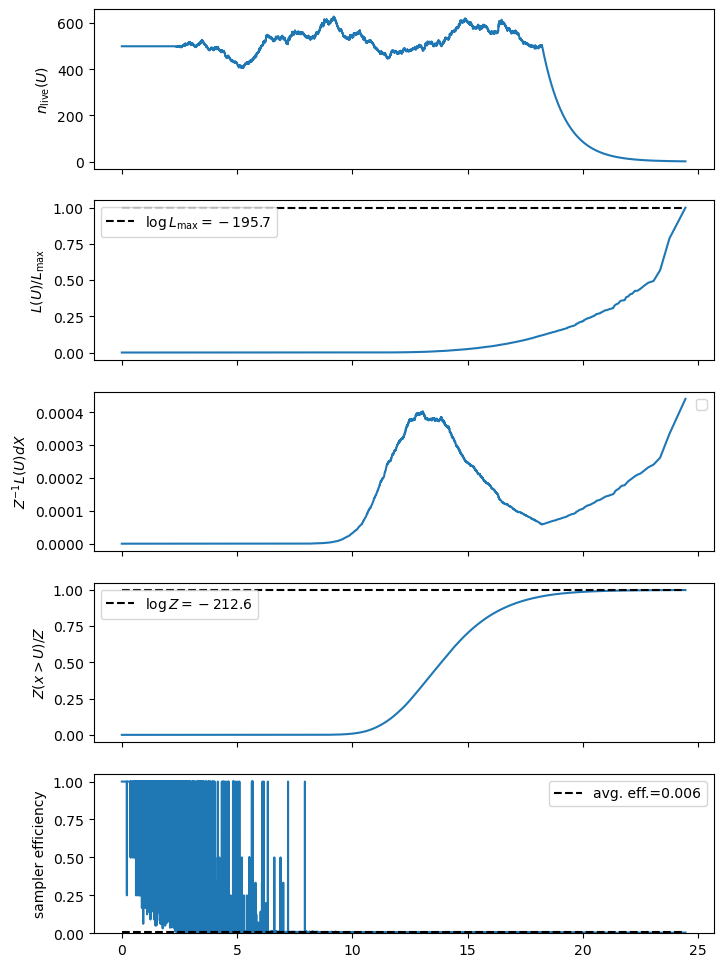

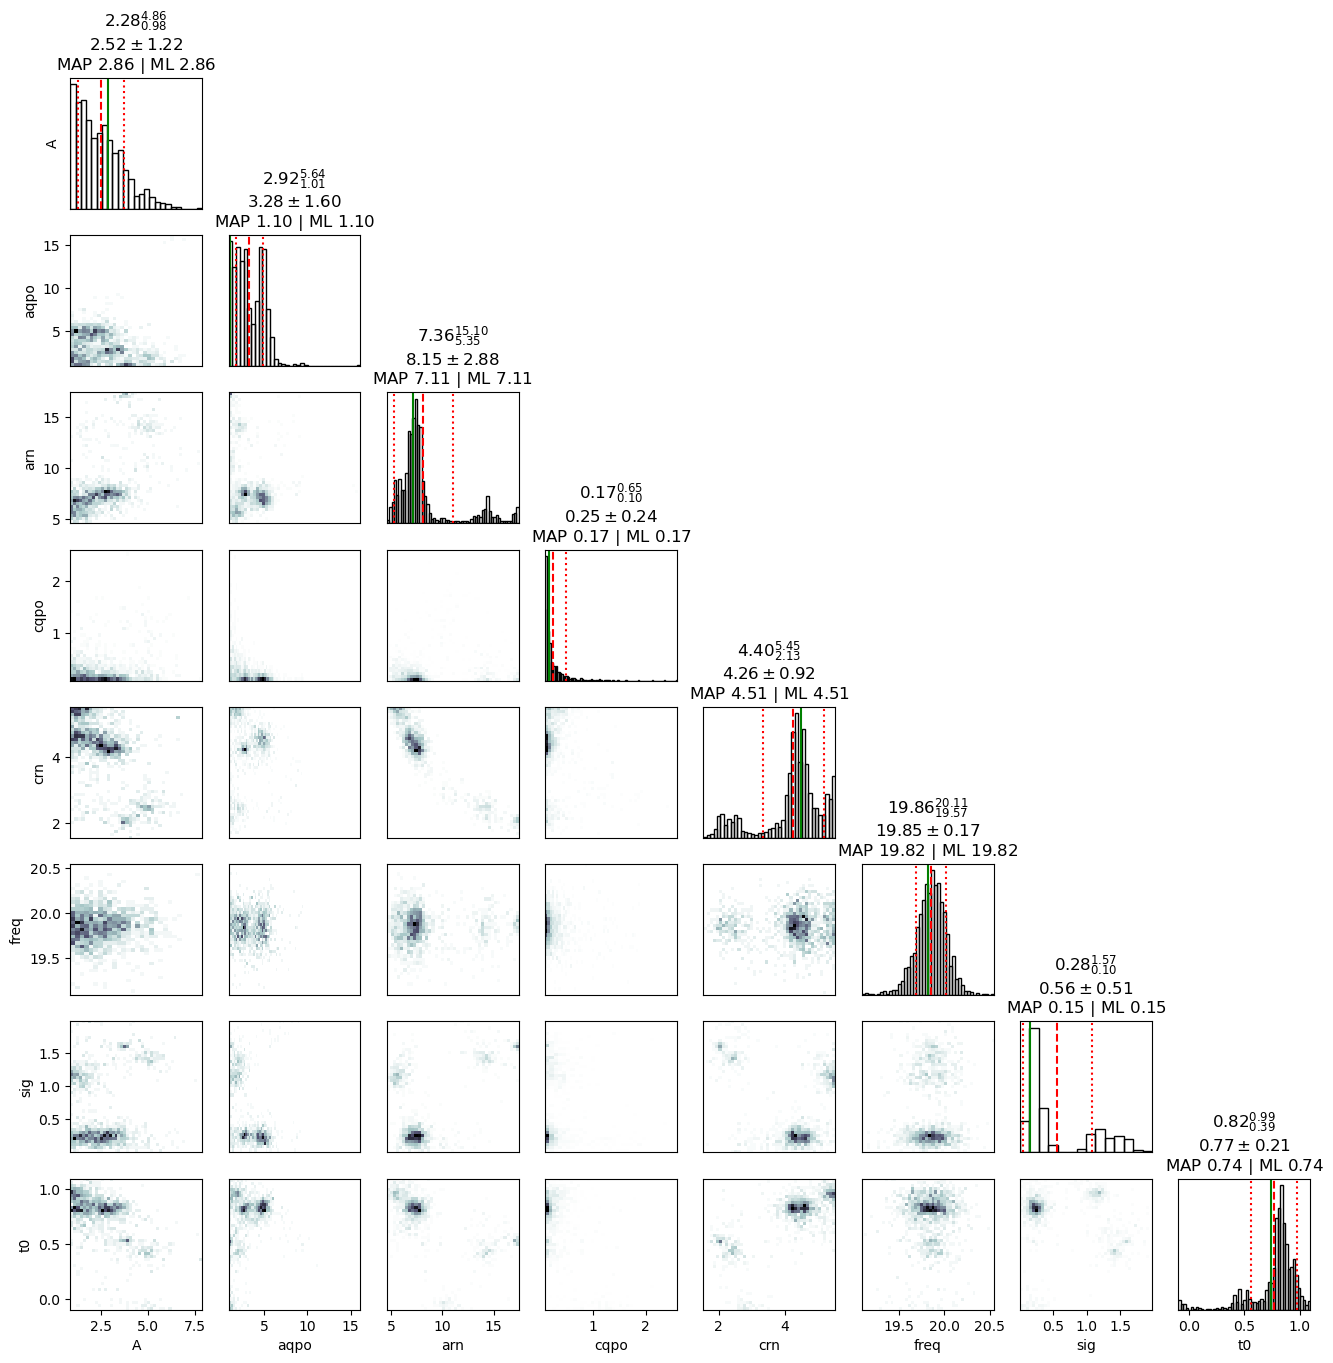

In [45]:
Results["QPOexact_ns"].plot_diagnostics(Results["QPOresults"])
Results["QPOexact_ns"].plot_cornerplot(Results["QPOresults"])

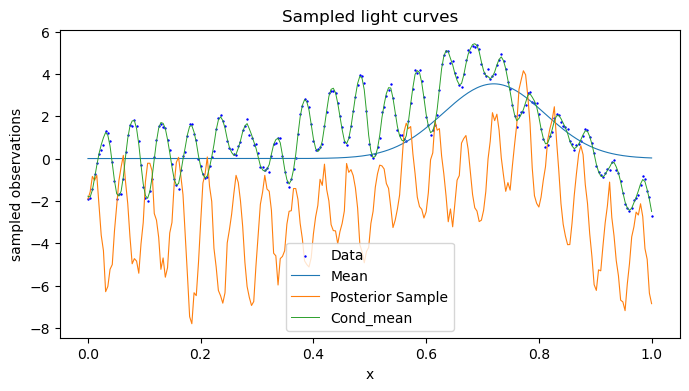

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(Times, lightcurve.T, lw=0.7, color = "b", label = "Data", s = 1)

post_qpoparams = {
    "arn": 5.71,    "crn": 1.35,
    "aqpo": 2.46,    "cqpo": 0.33,    "freq": 19.64
}
post_qpomeanparams = {
    "A": 3.53,    "t0": 0.72,    "sig": 0.09
}

gp = build_gp(post_qpoparams, post_qpomeanparams, Times, kernel_type = "QPO_plus_RN")
_ , cond_gp = gp.condition(lightcurve)
ax.plot(Times, gp.mean, lw=0.8, label = "Mean") 
ax.plot(Times, gp.sample(jax.random.PRNGKey(7)), lw=0.8, label = "Posterior Sample")
# When we are using the same key, then very similar samples are drawn
ax.plot(Times, cond_gp.mean, lw = 0.7, label = "Cond_mean")
# ax.plot(Times, RNresults.posterior_samples["mean"].T, lw=0.8, color = "r", label = "Mean")
ax.set_xlabel("x")
ax.set_ylabel("sampled observations")
ax.legend()
_ = plt.title("Sampled light curves")

In [ ]:
# BFrn, BFlqpo, BFhqpo = make_evidence_histogram(n = 200)

Higher value because no jitter added yet

In [46]:
BFrn, BFlqpo, BFhqpo = make_evidence_histogram(n = 5)

0
BF RN lightcurve  -8.296161335696695
BF LQPO lightcurve  -6.763255563058294
BF HQPO lightcurve  31.052999230547357
1
BF RN lightcurve  -4.612136479825153
BF LQPO lightcurve  -6.583735524554896
BF HQPO lightcurve  25.775898586129955
2
BF RN lightcurve  -8.120482821746236
BF LQPO lightcurve  0.8411347814312364
BF HQPO lightcurve  50.32577562550725
3
BF RN lightcurve  -1.9744078541585282
BF LQPO lightcurve  -3.986445344253525
BF HQPO lightcurve  -0.7401261350659638
4
BF RN lightcurve  -7.593347972320203
BF LQPO lightcurve  -7.428632683650164
BF HQPO lightcurve  5.835959652824272


In [19]:
BFrn, BFlqpo, BFhqpo = make_evidence_histogram(n = 5, start = 6)

0
BF RN lightcurve  -8.408091395788787
BF LQPO lightcurve  20.734401777062267
BF HQPO lightcurve  88.14364526276246
1
BF RN lightcurve  -5.837835508618139
BF LQPO lightcurve  55.7122915999352
BF HQPO lightcurve  154.27974426307767
2
BF RN lightcurve  -6.971213113613498
BF LQPO lightcurve  56.913591835915646
BF HQPO lightcurve  152.83944253592995
3
BF RN lightcurve  -5.602031036506688
BF LQPO lightcurve  5.8956997874224655
BF HQPO lightcurve  81.34645327941652
4
BF RN lightcurve  -7.626540676812631
BF LQPO lightcurve  10.961017020980606
BF HQPO lightcurve  86.0340928839871
